### Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') 
%config InlineBackend.figure_format='retina'

# Import data
df = pd.read_csv('./data/data.csv')
# Calculate timedelta between two different points in time
df['timedelta'] = df['time_s'] - df['time_s'].shift(1)

### Problem understanding

The first task can be reformulated as tilt correction problem based on GNSS and IMU data. GNSS coordinates are given in global reference frame, while IMU data is given in the local frame of the vehicle.

`Note!` I assume IMU data is given in local reference frame using Proper Euler Angles and not Tait-Bryan angles based on the given definition of pitch and roll.

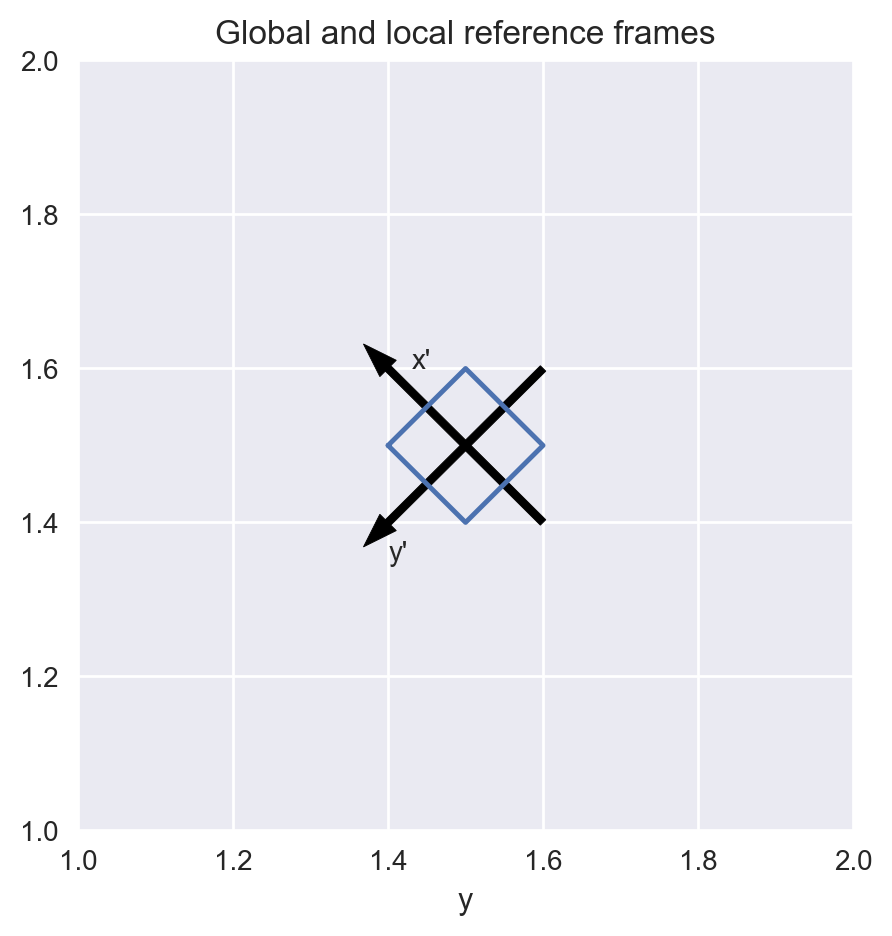

In [3]:
from src.visualization.visualize import plot_0
plot_0()

Thus, to calculate corrected GNSS coordinates we need to know the direction of local reference frame and then make respective shifts along its axis. We would like to calculate the angle of rotation between local and global reference frames, namely take points and two neighbouring timestamps and calculate the angles as arctan2(y_delta, x_delta).However, this is complicated by the fact that points contain tilt error, hence we would get incorrect angle of rotation.

`Solution to this problem:` from EDA we see that there exist several neighbouring points in the data where roll_deg are equal. In this points we can calculate "the actual" reference frame (the one that contains no tilt error). Having at least one such points allows us to reculaulate correct angles of rotation for all the points and make necessary adjustments along local reference frame's axes.

### Algorithm description

I have implemented the followng algorithm for tilt correction:

+ Take two neighbouring points (at t and t+1) and caluclate angle between x-axis in global reference frame and x-axis in local regerence frame as atan2(delta_y, delta_x): implemented in `calc_rot_angle`

+ Calculate the shift along x' and y' needed for correction (use simple trigonometry). implemented in `caluclate_shifts`

+ Apply shifts to get corrected coordinates. Here I assume that we first move along x-axis and then along y-axis. Implemented in `apply shifts`

+ Move to the next points (t+1 and t+2). Unroll corrected point at t+1 by the roll of point at t+2 to get the same roll for two points. Implemented in `calculate_backroll`

+ Repeat the steps

`Note!` Ideally, we would have two first points with equal roll to calculate correct rotation angle. However, this is not the case for given data. Hence, we first calculate angles with some error, but as soon as we meet two points with the same roll we can recaluclate previous points coordinates applying the algorithm backwads. This is also implemented in my code.

### Exploatory data analysis

From EDA we can see:

+ Vehicle is moving along straight line but its movement is not allignet with global reference frame.
+ Also, we see that GNSS and IMU updates come at approximately with the frequency of 0.23 seconds
+ Pitch and roll will help us to see whether we calculated shifts along axis correctly

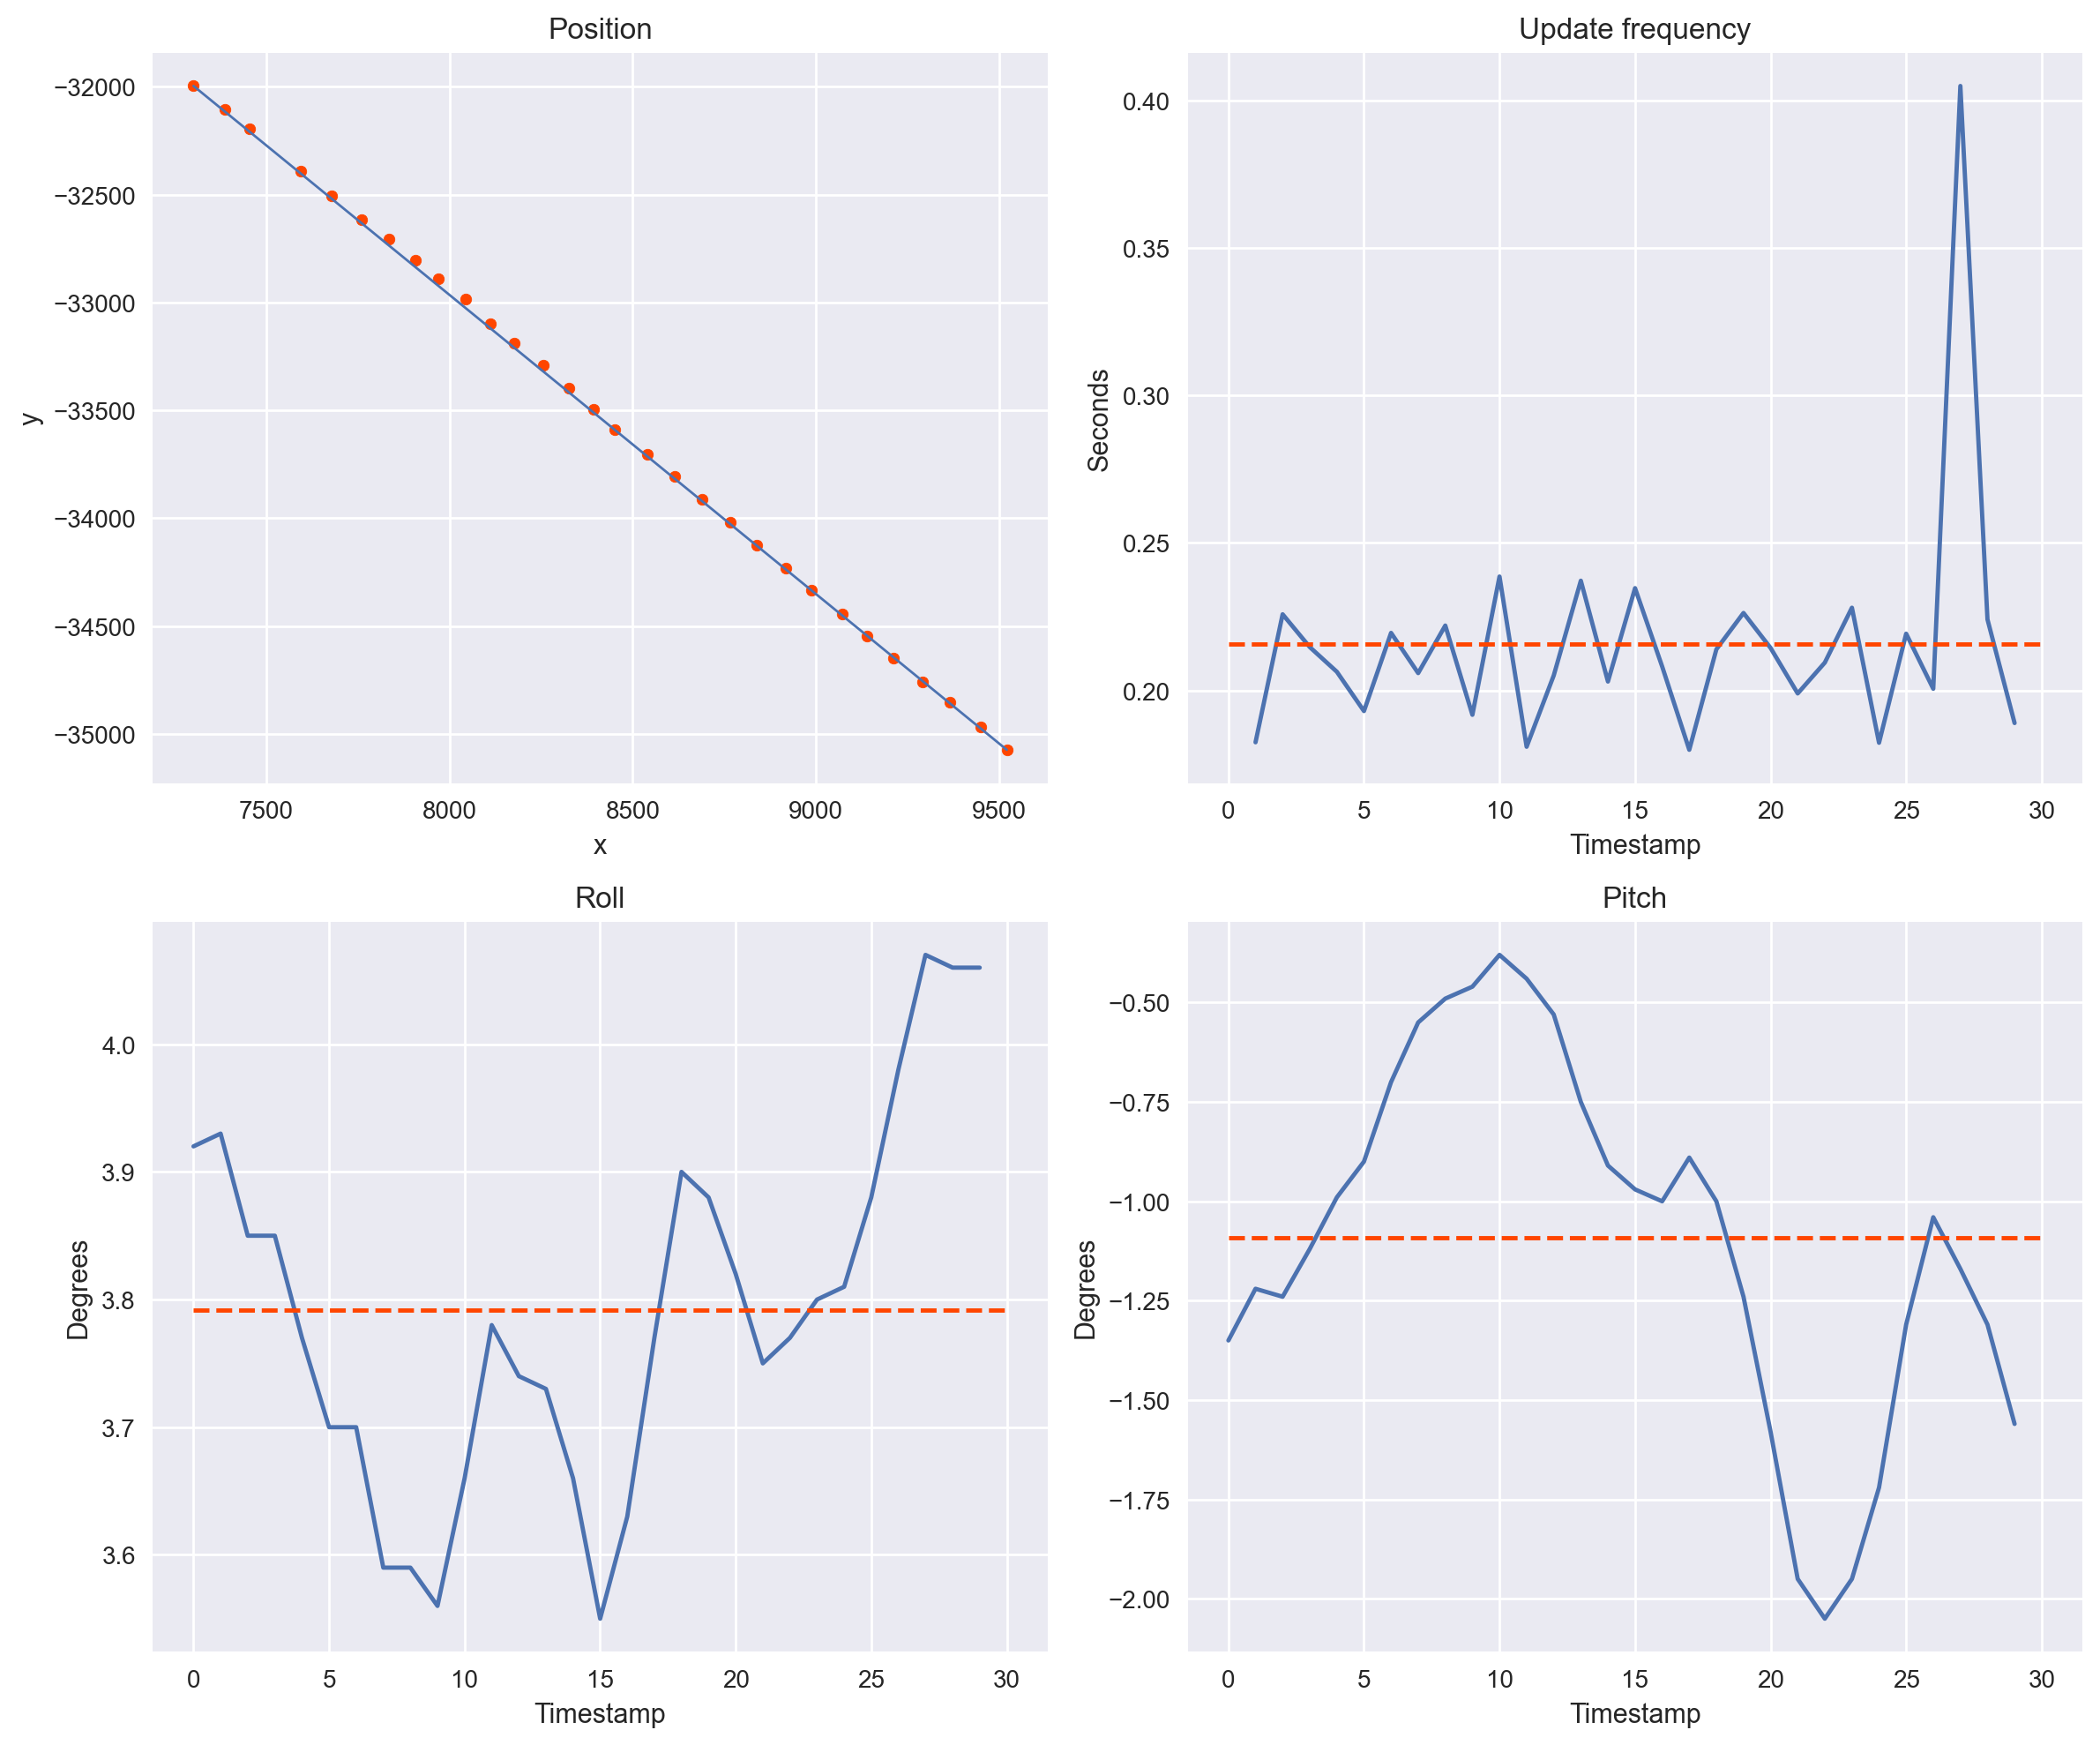

In [4]:
from src.visualization.visualize import EDA
EDA(df)

### 1. For each point calculate the projection of the GNSS module post on the moving plane

Here (in `transfrom` function) I imitate live-time recieval of data reading row by row form csv and writing to `DataSet` data class. This is close to what we get in reality (can use only current and past data for calculations at each step).

In [5]:
from src.data.make_dataset import DataSet, make_new_df
from src.functions.functions import transfrom

# Make transformations
dataset = DataSet()
transfrom(df, dataset, recalc=True)
df_new = make_new_df(dataset)

df_new.head()

,time_s,x_mm,y_mm,roll_deg,pitch_deg,angle,shift,adj_x,adj_y
0,1.621693e+09,9521.0,-35074.0,3.92,-1.35,"(2.17642247204836, 3.7472187988432566)","(35.25696930594666, 102.54531603850307)",9416.621818,-35103.390317
1,1.621693e+09,9450.0,-34970.0,3.93,-1.22,"(2.194354163572309, 3.7651504903672057)","(31.862012661293246, 102.8065013772332)",9347.935964,-35004.165729
2,1.621693e+09,9365.0,-34853.0,3.85,-1.24,"(2.237704531034207, 3.8085008578291037)","(32.38733464457786, 100.71693164909858)",9265.829395,-34889.851470
3,1.621693e+09,9291.0,-34759.0,3.85,-1.12,"(2.237704531034207, 3.8085008578291037)","(29.25349706715814, 100.71693164909858)",9193.767860,-34798.313845
4,1.621693e+09,9211.0,-34649.0,3.77,-0.99,"(2.1696294394073585, 3.740425766202255)","(25.860766522127406, 98.6271655681521)",9114.957389,-34683.233227


### Results:

+ Shifts along the axis are calculated correctly
    + Shift along x-axis and pitch are inversely related. If pitch is negative, then we should move along x-axis in the positive direction to correct the error (from rear part to front part)
    + Shift along y-axis and roll are directly related. If roll is positive, then we should move along y-axis in the positive direction to correct the error (from right side to left side)

+ Corrections are calculated correctly
    + In the dataset the vehicle has always positive roll and negative pitch. Hence, correction should always move froward along x-axis (positive direction) and from right to left along y-axis (postitive direction)

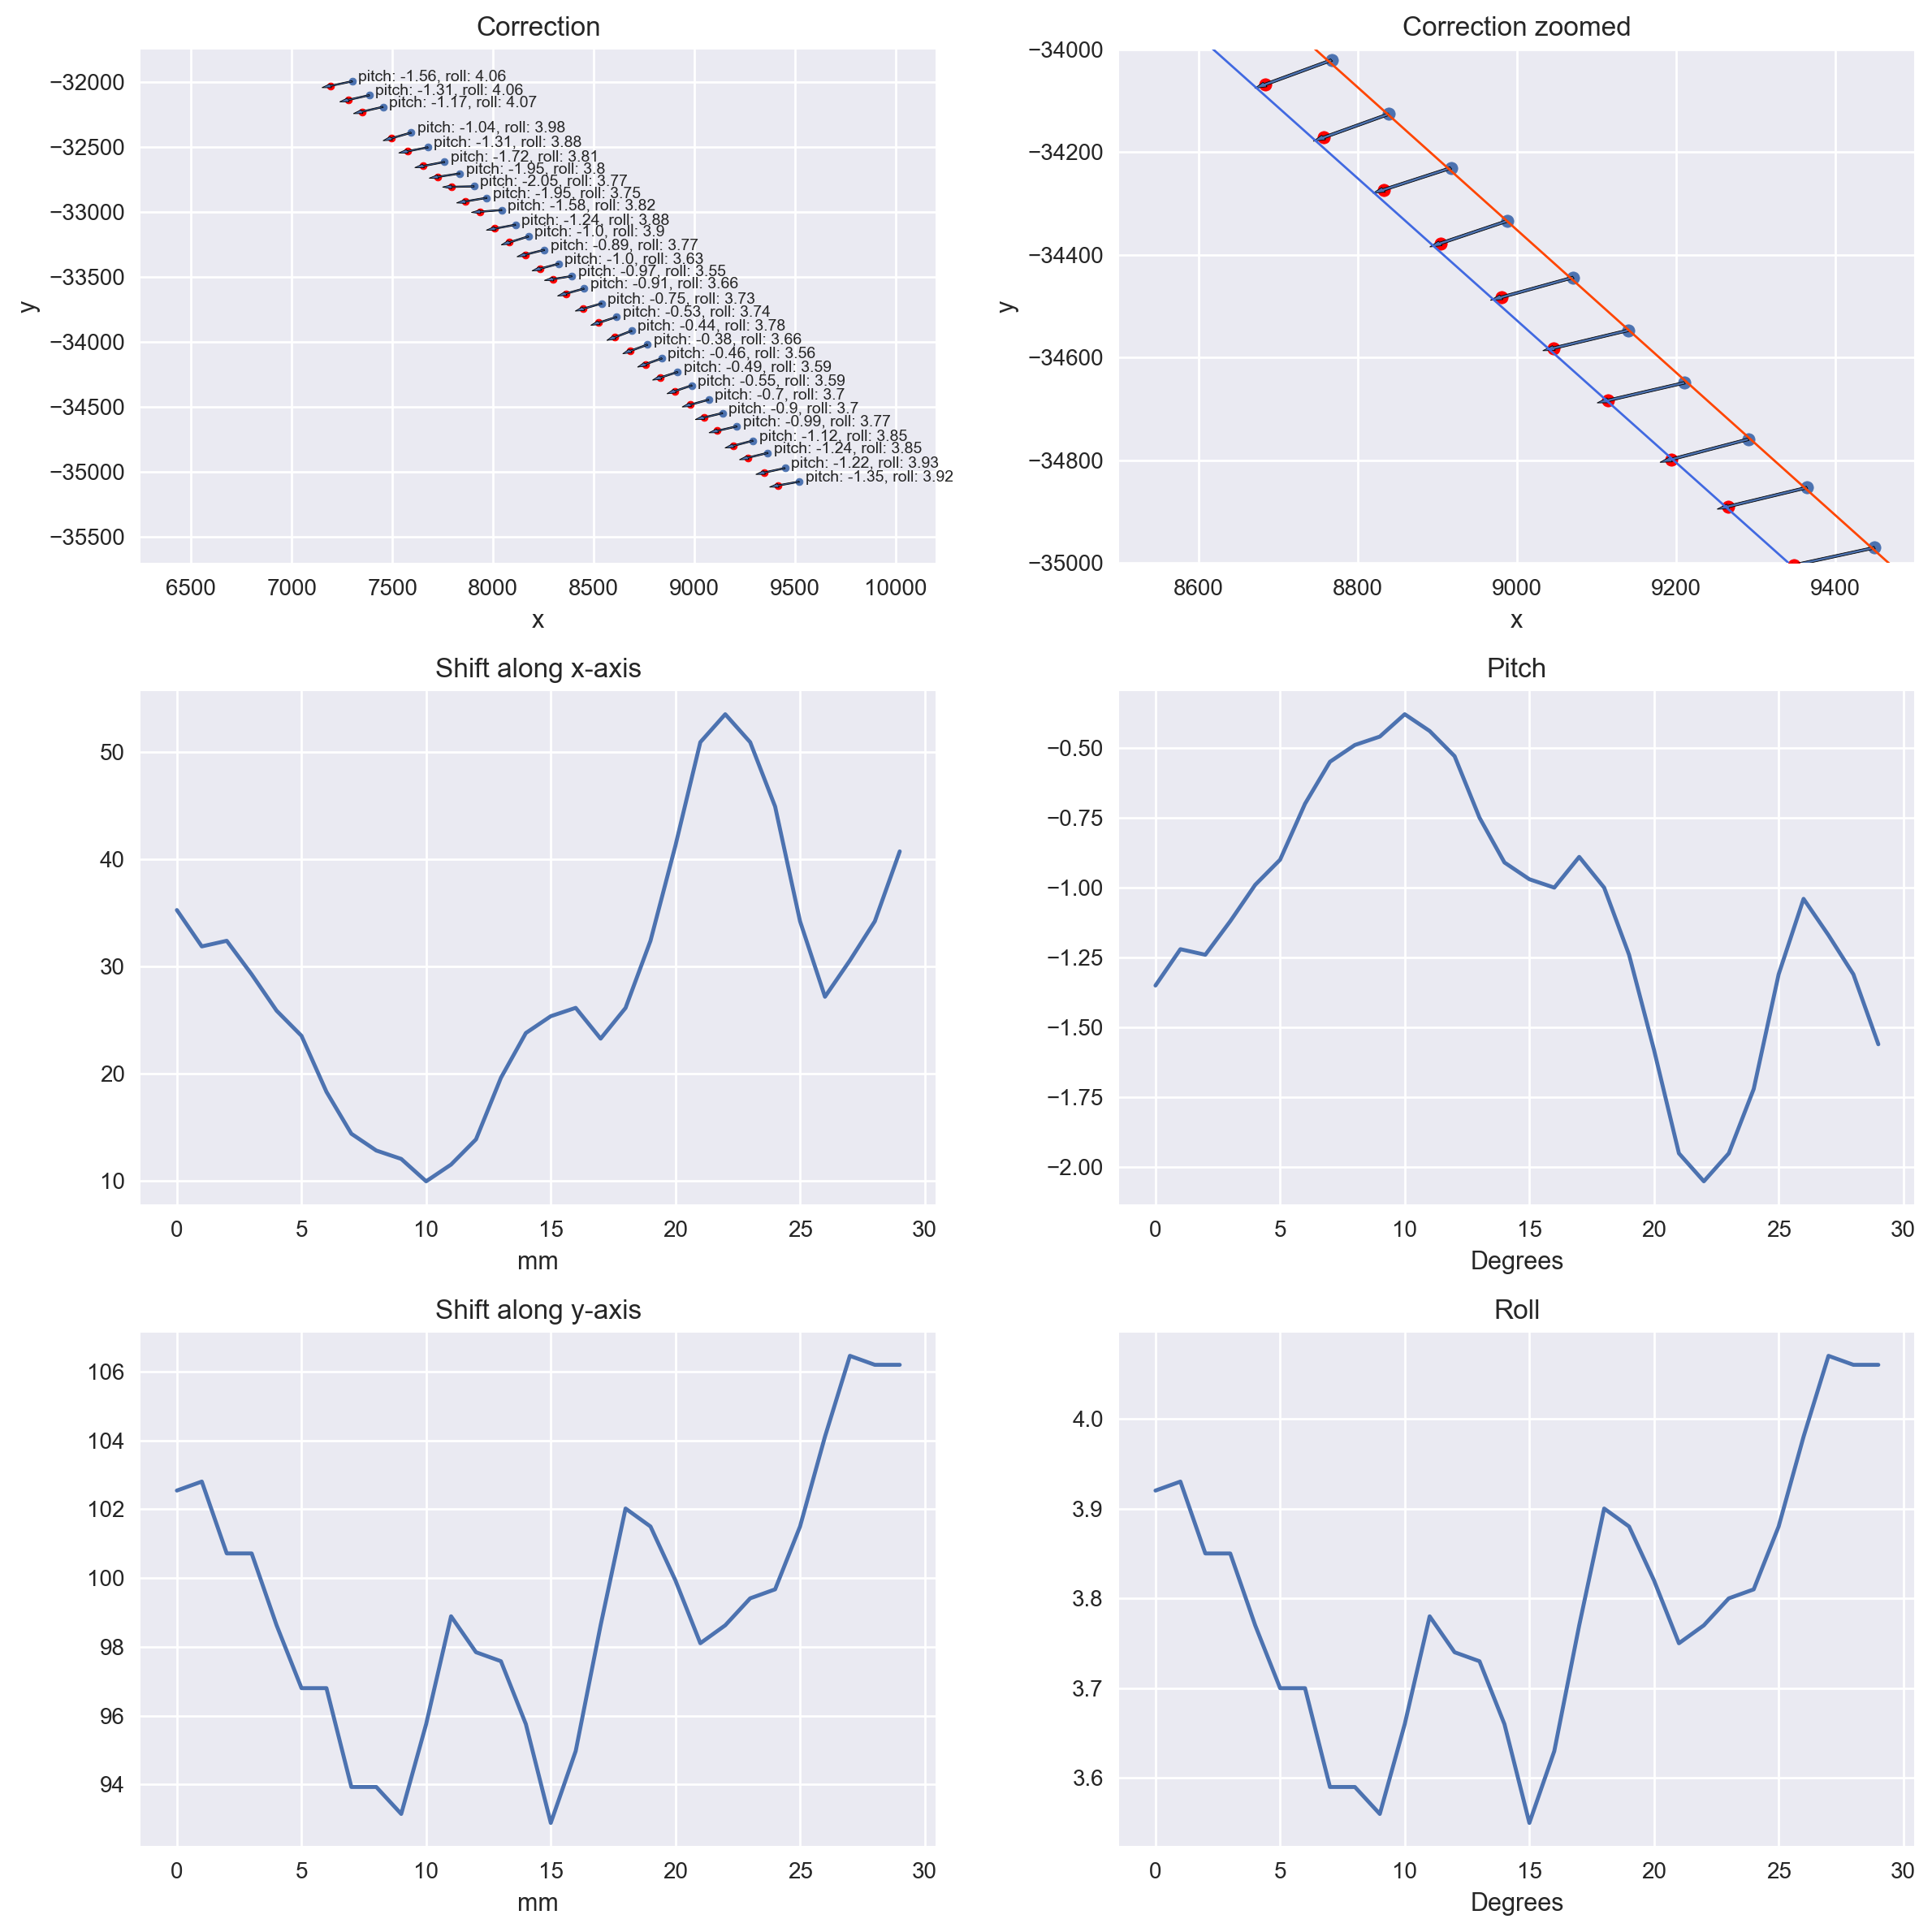

In [6]:
from src.visualization.visualize import post_plot_1
post_plot_1(df_new)

### 2. For each point calculate the vehicles heading (vehicle is moving smoothly straight ahead)

If my understanding is correct, heading of the vehicle will be just the direction from point at `t` to the point at `t+1` after the correction is applied. Usually the heading is reported as the angle between north direction and movement vector, however here it is not possible. Thus, I report the angle between x-axis of global reference frame and direction at each point in time. Also, I draw a graph with directions at each point.

In [7]:
from src.data.make_dataset import extract_angles
angles = extract_angles(dataset)

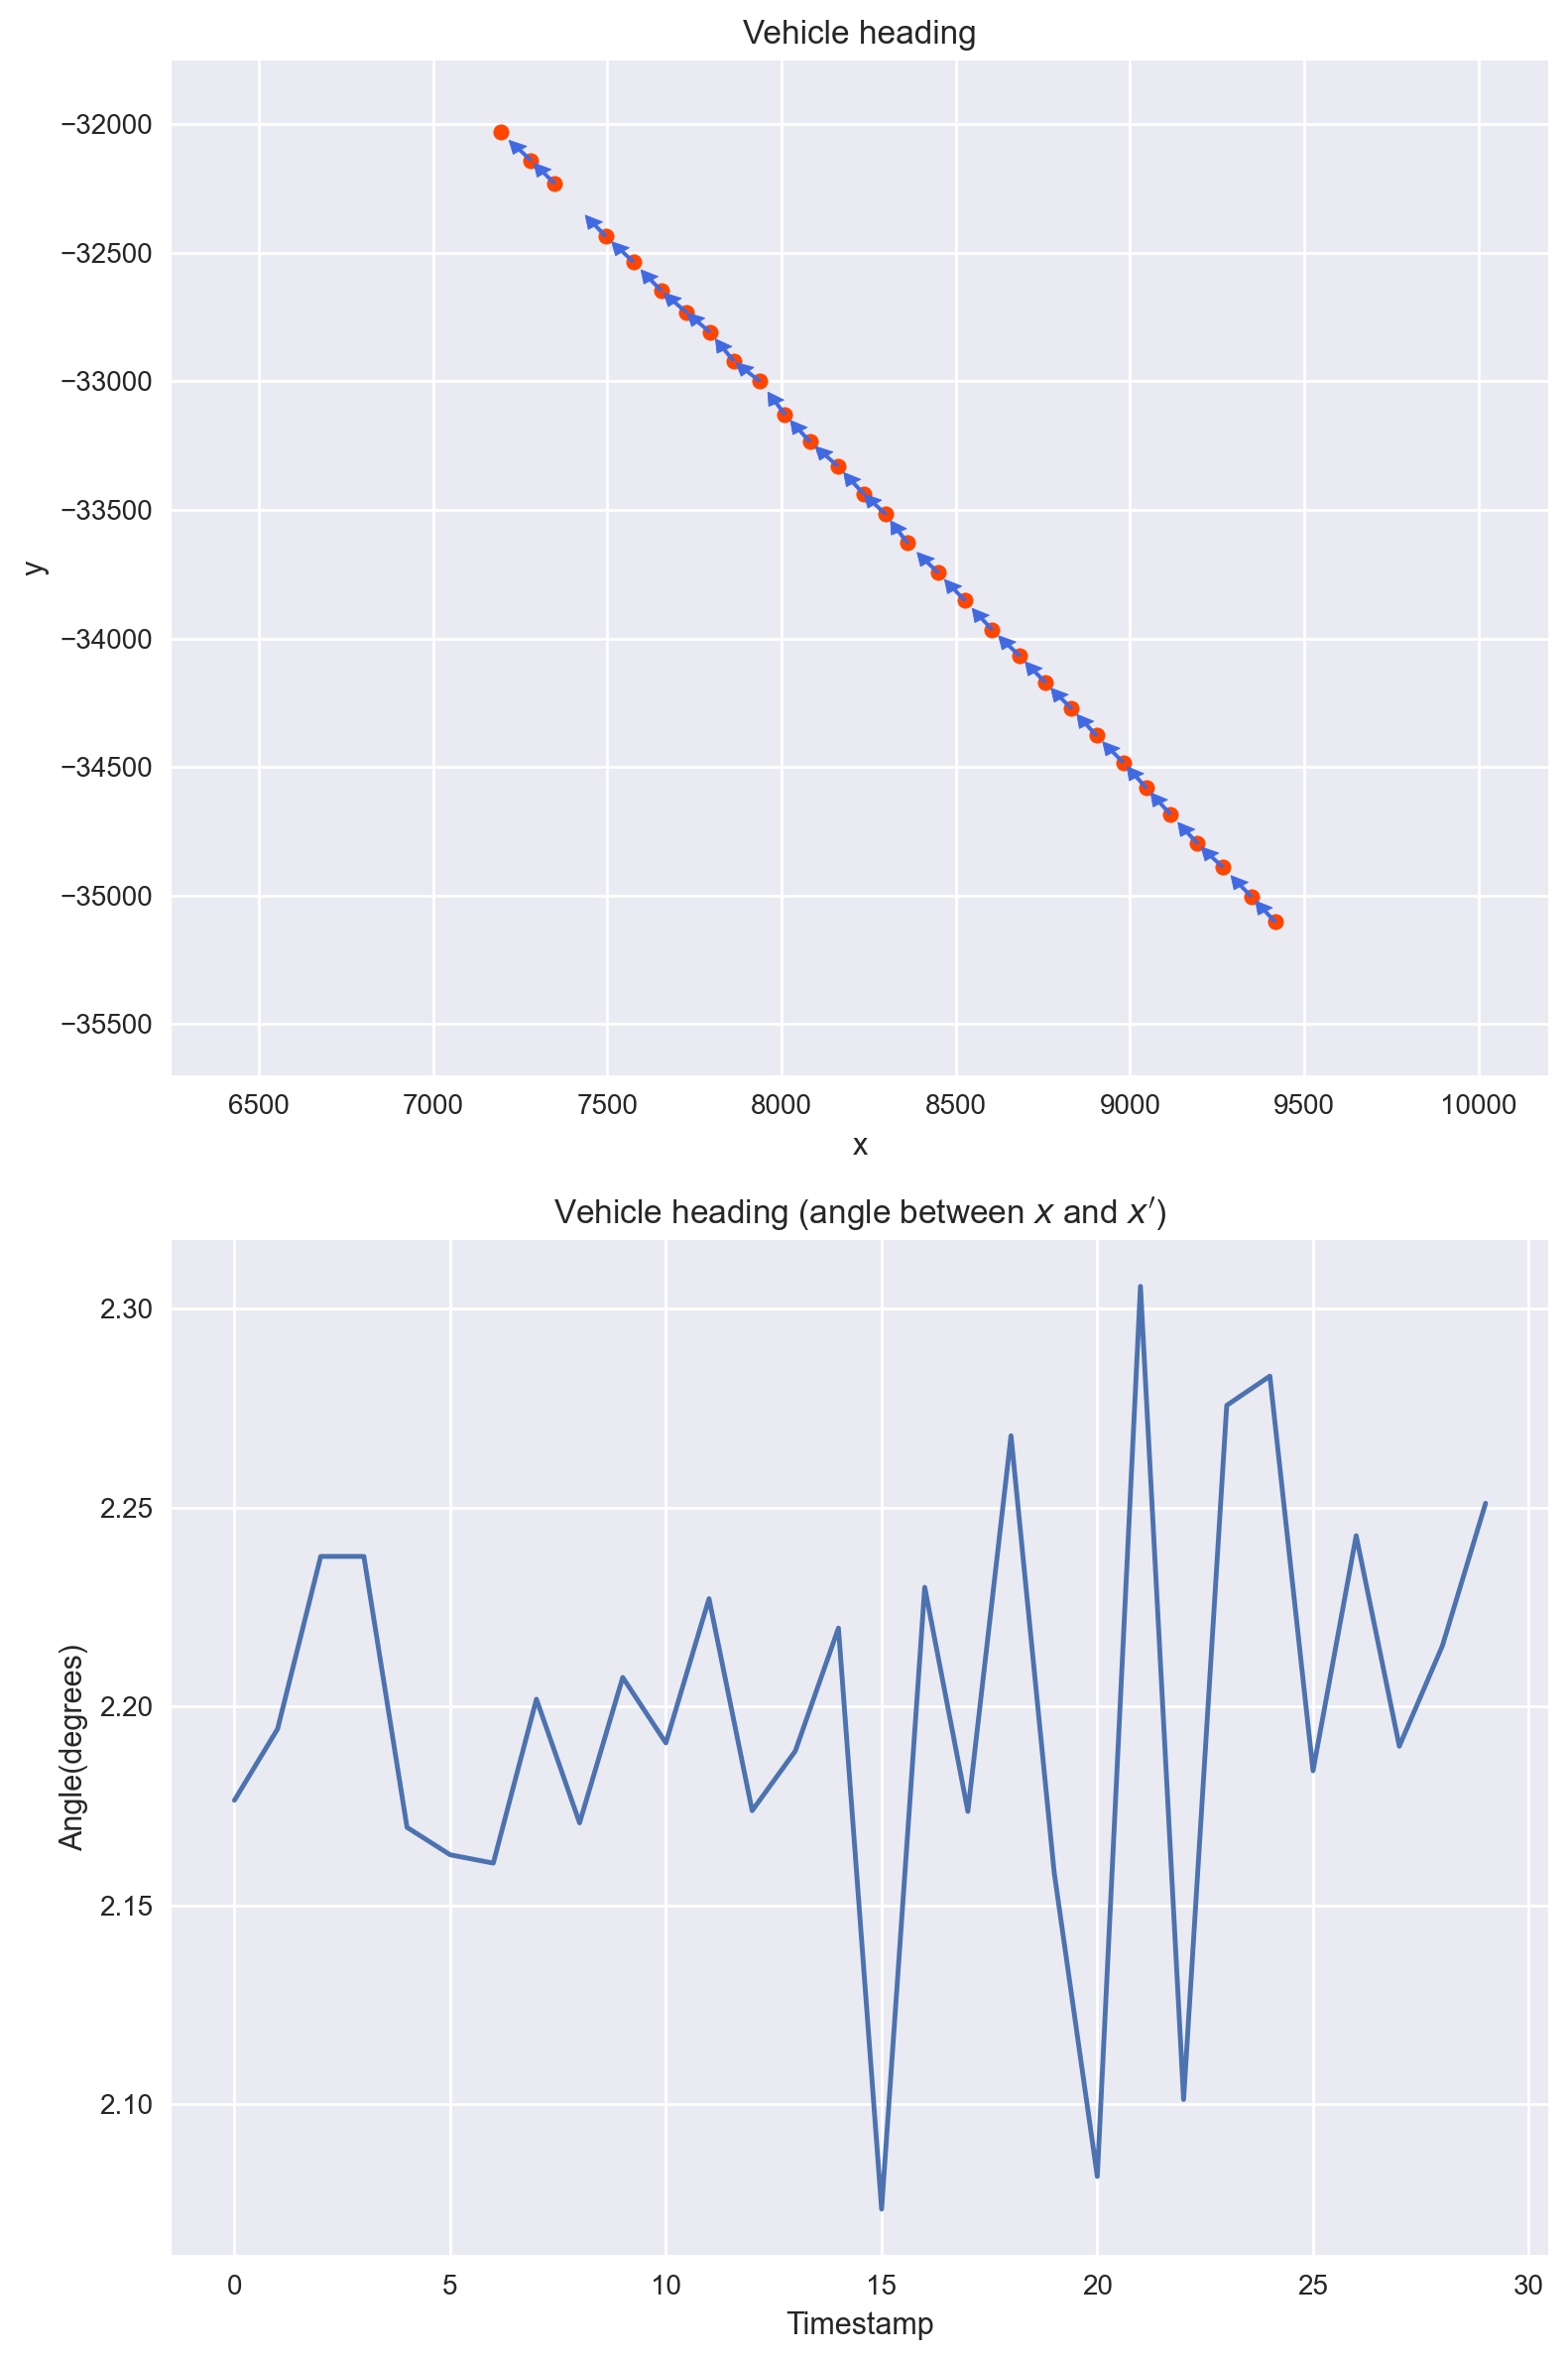

In [8]:
from src.visualization.visualize import post_plot_2
post_plot_2(df_new, angles)